In [1]:
# Data Manipulation Libraries: Standard dataframes and array libraries
import pandas as pd
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile
# from datetime import datetime
import datetime as dt

# Data Visualization Libraries:
import matplotlib.pyplot as plt
import seaborn as sns

# K-means clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Displaying plots in jupter notebook
%matplotlib inline
# Displaying pandas columns and rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# import data
df = pd.read_excel("static/data/online_retail.xlsx", sheet_name="Online Retail")

# Clean Data

 - Inspect Datatypes
 - Drop missing values in key column
 - Change datatypes as needed

In [5]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## <font color="blue">Note: </font>Many missing values in the <code>CustomerID</code> Column

In [6]:
# Drop rows that have missing customerID values
df = df.dropna(subset=['CustomerID'])

In [9]:
# Convert customerID column to integers
df.astype({'CustomerID': 'int32'}).dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int32
Country                object
dtype: object

# Step 1: Assign Customer to a <font color="red">Time Cohort</font> <code>CohortMonth</code>

 - Is a customer segmentation method used to groups customers based on a time assignment<br>
 - I this exerice, we will group customers based on the month-year they made their first purchase.<br>
 - We will then track the customer retention, and several purchasing behavior metrics.

<b>General Steps:</b><br>
<ol>
    <li>Create an 'InvoiceMonth' column from InvoiceDate column</li>
    <li>Group all InvoiceDates by customer</li>
    <li>Extract the first date of each month in grouped data, and assign to new column CohortMonth</li>
    <li>Assign each customer a Cohort Index</li>
</ol>

In [10]:
# Function that retunes the year and month from a datetime column: year-month-01
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

In [13]:
# Create a new column 'InvoiceMonth' by 
# applying the function to the 'InvoiceDate' column
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)

In [14]:
# Groups data by custemerID
grouping = df.groupby('CustomerID')['InvoiceMonth']

In [15]:
# Create a new column 'CohortMonth' that takes the groupby object, 
# and assigns the min invoiceMonth date
df['CohortMonth'] = grouping.transform('min')

# Step 2: Create <code>CohortIndex</code>

 - The cohort index is a number between 1 to 13 that is used to track the number of active customers across time.
 - Each index integr represents a month
 - The index is calculated by:<br>
 <code>years_diff * 12 + months_diff + 1</code>
 -  <code>years_diff</code> and <code>months_diff</code> are <b>offeset values</b> consists of the year and month difference between the most recent invoice date and the first invoice date.

In [16]:
# Function that returns the integer values dates
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day =  df[column].dt.day
    return year, month, day

### Calculate Offset Values
 - Step a: Get the invoice year and invoice month for each transcation
 - Step b: Get the cohort year and cohort month
 - Step c: Calculate <code>year_diff</code>
 - Step d: Calculate <code>months_diff</code>
 - Step e: Calculate the <code>CohortIndex</code> for each instance in dataframe, and add that value in a new <code>CohortIndex</code> column

In [17]:
# Get the invoice year and invoice month from InvoiceMonth column
# For invoice_year, he values will range between 2010 or 2011
# For invoice_month, it will be 1 - 12
invoice_year, invoice_month, _ = get_date_int(df, 'InvoiceMonth')

In [18]:
# Get the cohort year and cohort month from CohortMonth column
# For cohort_year, the values will range between 2010 or 2011
# For cohort_month, the values will range between 1 - 12
cohort_year, cohort_month, _ = get_date_int(df, 'CohortMonth')

In [61]:
# Calculate the year the individual has been a customer
# The values will range between 0 and 1
years_diff = invoice_year - cohort_year

In [62]:
# Calculate the months the individual has been a customer
# The values will range between -11 and 11
months_diff = invoice_month - cohort_month

In [26]:
# Will assign a customer along a CohortIndex.
# Cohortindex is calculated by using the offset values for each instance in dataframe
df['CohortIndex'] = years_diff * 12 + months_diff + 1

In [69]:
# Evaluate CohortIndex
df.CohortIndex.value_counts(sort=False).values

1     119191
2      29147
3      27493
4      28075
5      25926
6      27576
7      24214
8      24200
9      23672
10     24075
11     21331
12     24520
13      7409
Name: CohortIndex, dtype: int64

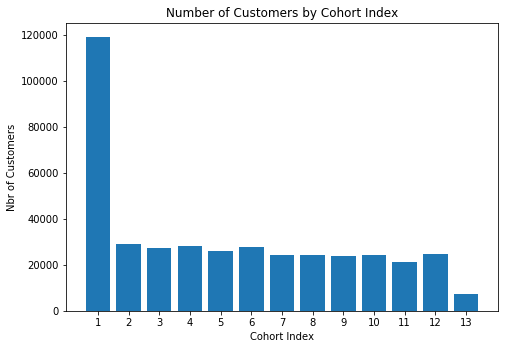

In [90]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = list(df.CohortIndex.unique())
values = df.CohortIndex.value_counts(sort=False).values
ax.bar(labels,values)
plt.ylabel("Nbr of Customers")
plt.xlabel("Cohort Index")
plt.xticks(labels)
plt.title("Number of Customers by Cohort Index")
plt.show()

# Step 3: Determine the number of monthly active customers for each cohort

 - Step a: Group the dataframe by the cohort month and cohort index
 - Step b: Group by unique customers
 - Step c: Resent the index so that the CohortMonth is a column and not an index
 - Step d: Create a pivot table named <code>cohort_counts</code> that has:<br>
 The <code>CohortMonth</code> as the row index<br>
 The <code>CohortIndex</code> as the column<br>
 each cell has the total number of unique <code>CustomerID</code><br>

In [91]:
# Group data by CohortMonth and CohortIndex
grouping = df.groupby(["CohortMonth", "CohortIndex"])

In [92]:
# To return only unique CustomerID instances
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)

In [95]:
# Reset the object index
cohort_data = cohort_data.reset_index()

In [39]:
# Create a pivot table, index (row labels) is the cohort month
# The column headers are the cohortIndex 1 - 13
# Values in each cell are the count of Customers
cohort_counts = cohort_data.pivot(index="CohortMonth",
                                 columns = 'CohortIndex',
                                  values="CustomerID"
                                 )

In [46]:
# View pivot table
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02-01,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05-01,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<b><font color="blue">Note:</font>
 - The number of customers drops months after they made their first transactions.
 - The number of customers has dropped by more than half after the first cohort month.</b>

# Step 4: Calculate and Visualize Customer Retention

 - Customer retention is the number of customers that remain active with the company after a given amount of time.
 - Activity is defined by making purchases within a given period.
 - This will generate a similar pivot table as with <code>cohort_counts</code> but presents a percentage rather than an absolute number of customers.
 <br><br>
 - Step a: Get the count of unique customers by cohot month <code>cohort_sizes</code>
 - Step b: Divide each row of the <code>cohort_counts</code> pivot table by the value in the first column of each row
 - Step c: For ease, round each cell, and multiple by 100 to convert decimal to percent.
 - Customer retention is calculated by:<br>
 <code>the cohort size in a given month/initial cohort size</code>
 - Step d: Visualize data using a heatmap

In [42]:
# Store values from first column, which is the total starting point
cohort_sizes = cohort_counts.iloc[:,0]

In [43]:
# Use .divide() to divide all values in table by cohort_sizes
# axis=0, will divide by the rows
retention = cohort_counts.divide(cohort_sizes, axis=0)

In [44]:
# Use the .round() method to format decimals then make look into a percent
retention.round(3) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,38.2,33.4,38.7,36.0,39.7,38.0,35.4,35.4,39.5,37.3,50.0,27.4
2011-01-01,100.0,24.0,28.3,24.2,32.8,29.9,26.1,25.7,31.1,34.7,36.8,15.0,NaN
2011-02-01,100.0,24.7,19.2,27.9,26.8,24.7,25.5,28.2,25.8,31.3,9.2,NaN,NaN
2011-03-01,100.0,19.1,25.5,21.8,23.2,17.7,26.4,23.9,28.9,8.9,NaN,NaN,NaN
2011-04-01,100.0,22.7,22.1,21.1,20.7,23.7,23.1,26.1,8.4,NaN,NaN,NaN,NaN
2011-05-01,100.0,23.7,17.2,17.2,21.5,24.4,26.5,10.4,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,20.9,18.7,27.2,24.7,33.6,10.2,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,20.9,20.4,23.0,27.2,11.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,25.1,25.1,25.1,13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


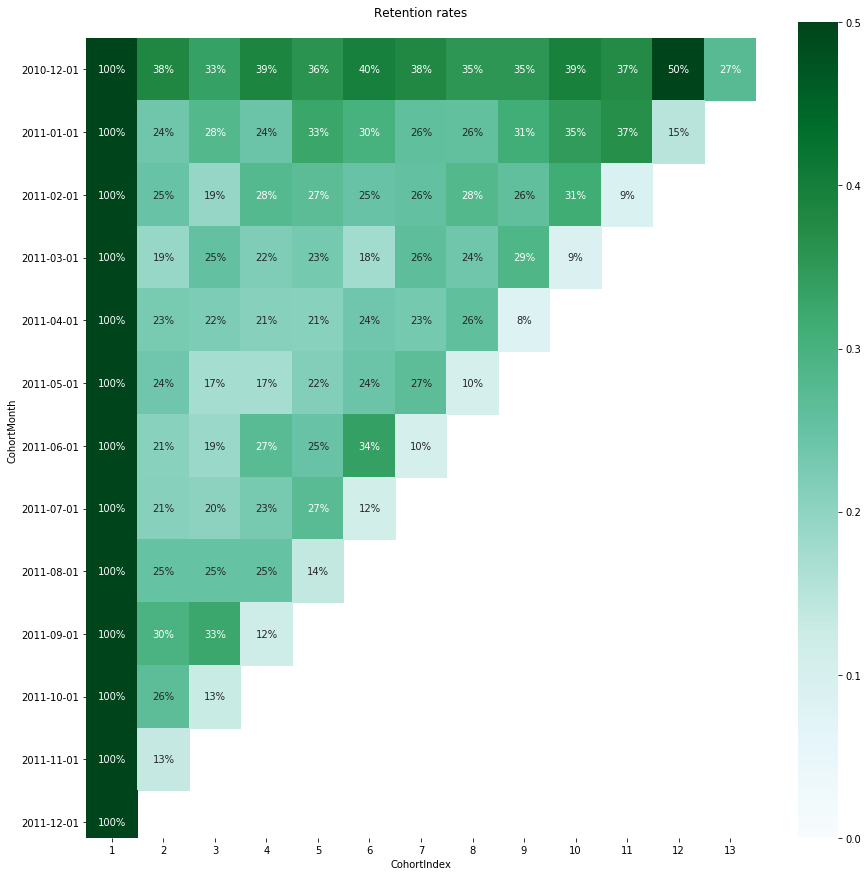

In [108]:
plt.figure(figsize=(15,15))
plt.title('Retention rates')
chart = sns.heatmap(data=retention,
           annot=True,
            fmt='.0%',
            vmin= 0.0,
            vmax=0.5,
            cmap='BuGn',
            yticklabels=retention.index.strftime('%Y-%m-%d')
           )

# Makes sure the plot is visible
chart.set_ylim(len(retention)-0.25, -0.25)
# Rotates the ytick labels
chart.set_yticklabels(
    chart.get_yticklabels(), 
    rotation=0
)
# plt.savefig("filepath/filename.format", bbox_inches='tight')
plt.show()

<b><font color="blue">Note:</font>
 - The percent of customers drops by about 70% after the first cohort index and does not seem to recover</b>

# Step 5: Calculate and Visualize the Average Quantity of Items Purchased by Time Cohort

 - Information on number of purchases made by cohort is informative
 - Step a: Group dataframe by <code>["CohortMonth", "CohortIndex"]</code> again
 - Step b: Group again by <code>Quantity</code> and calculate the mean of that quantity
 - Step c: Reset the index so that the CohortMonth and CohortIndex are columns in the dataframe again
 - Step d: Create a pivot table named <code>average_quantity</code> that has:<br>
 The <code>CohortMonth</code> as the row index<br>
 The <code>CohortIndex</code> as the column<br>
 each cell has the mean number of <code>Quantity</code>purchased<br>
 - Step e: Visualize data using heatmap

In [96]:
# Step a: Group dataframe by ["CohortMonth", "CohortIndex"] again
grouping = df.groupby(["CohortMonth", "CohortIndex"])

In [98]:
# Step b: Group again by Quantity and calculate the mean of that quantity
cohort_data = grouping['Quantity'].mean()

In [99]:
# Step c: Reset the index so that the CohortMonth and CohortIndex are columns in the dataframe again
cohort_data = cohort_data.reset_index()

In [100]:
# Step d: Create a pivot table named average_quantity 
average_quantity = cohort_data.pivot(index='CohortMonth',
                                    columns="CohortIndex",
                                     values='Quantity'
                                    )

In [101]:
# round values to 1 decimal place
average_quantity.round(1)

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,11.0,14.6,15.0,14.8,12.9,14.3,15.2,14.8,16.7,16.7,17.3,12.8,14.8
2011-01-01,10.0,12.6,12.3,10.9,12.2,14.9,14.2,14.4,11.4,9.9,9.1,9.5,NaN
2011-02-01,10.8,12.1,18.6,12.0,11.1,11.4,13.3,12.4,10.3,11.9,12.6,NaN,NaN
2011-03-01,9.8,9.9,12.2,9.5,13.6,12.3,13.2,12.2,10.5,8.9,NaN,NaN,NaN
2011-04-01,9.8,10.1,9.4,11.6,11.5,8.2,9.7,9.3,7.3,NaN,NaN,NaN,NaN
2011-05-01,10.9,9.0,13.9,11.8,10.9,8.7,10.1,7.4,NaN,NaN,NaN,NaN,NaN
2011-06-01,10.3,13.7,10.5,13.3,10.2,9.8,9.3,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,9.7,12.7,7.1,7.8,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,9.9,6.0,5.3,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


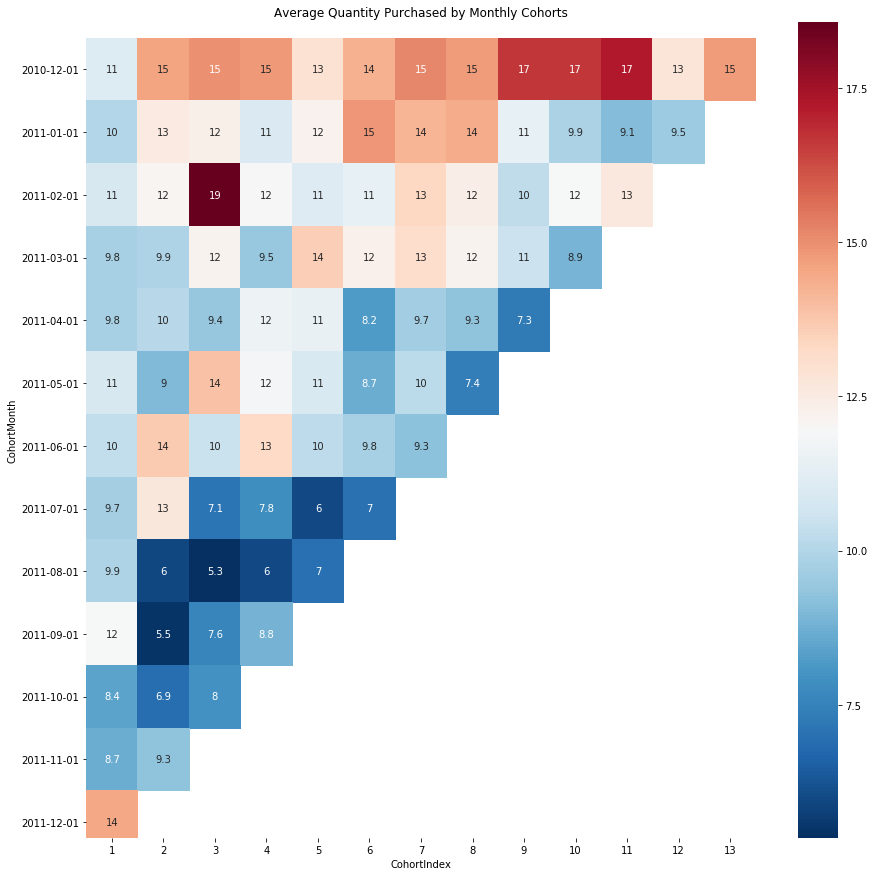

In [116]:
plt.figure(figsize=(15,15))
plt.title('Average Quantity Purchased by Monthly Cohorts')
chart = sns.heatmap(data=average_quantity,
           annot=True,
            cmap='RdBu_r',
            yticklabels=retention.index.strftime('%Y-%m-%d')
           )

# Makes sure the plot is visible
chart.set_ylim(len(retention)-0.25, -0.25)
# Rotates the ytick labels
chart.set_yticklabels(
    chart.get_yticklabels(), 
    rotation=0
)
# plt.savefig("filepath/filename.format", bbox_inches='tight')
plt.show()

<b><font color="blue">Note:</font>
 - Average quantity purchased fluctuated between 5 - 17
 - The first time cohort seem to purchase the highest quantity
 - No obvious pattern or seasonality in quantity purchased</b>

# Step 6: Calculate and Visualize Average Purchase Price

 - Calculate the average price metric and analyze if there are any differences in shopping patterns across time and across cohorts.
 - Step a: Group dataframe by <code>["CohortMonth", "CohortIndex"]</code> again
 - Step b: Group again by <code>UnitPrice</code> and calculate the mean
 - Step c: Reset the index so that the CohortMonth and CohortIndex are columns in the dataframe again
 - Step d: Create a pivot table named <code>average_price</code> that has:<br>
 The <code>CohortMonth</code> as the row index<br>
 The <code>CohortIndex</code> as the column<br>
 each cell has the mean <code>UnitPrice</code>paid<br>

In [103]:
# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = df.groupby(['CohortMonth', 'CohortIndex']) 

In [104]:
# Calculate the average of the unit price column
cohort_data = grouping['UnitPrice'].mean()

In [105]:
# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

In [106]:
# Create a pivot 
average_price = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='UnitPrice')
average_price.round(1)

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,3.2,3.2,3.2,3.6,2.9,5.0,3.2,3.2,3.5,3.0,3.3,2.8,2.8
2011-01-01,3.5,3.7,3.1,8.4,3.2,3.2,2.9,2.7,2.6,5.5,2.9,2.6,NaN
2011-02-01,3.3,4.4,4.8,3.1,3.0,2.8,2.8,3.2,2.9,2.9,3.2,NaN,NaN
2011-03-01,3.3,5.0,3.7,3.3,3.6,2.8,2.8,2.8,2.7,2.5,NaN,NaN,NaN
2011-04-01,3.4,4.0,3.3,2.7,3.0,2.9,2.9,2.8,2.6,NaN,NaN,NaN,NaN
2011-05-01,4.6,3.2,2.6,3.2,2.7,2.5,2.6,2.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,10.4,3.2,3.3,2.8,2.6,3.5,2.3,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,4.5,3.5,2.7,2.7,2.4,2.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,3.0,5.4,5.7,7.0,6.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


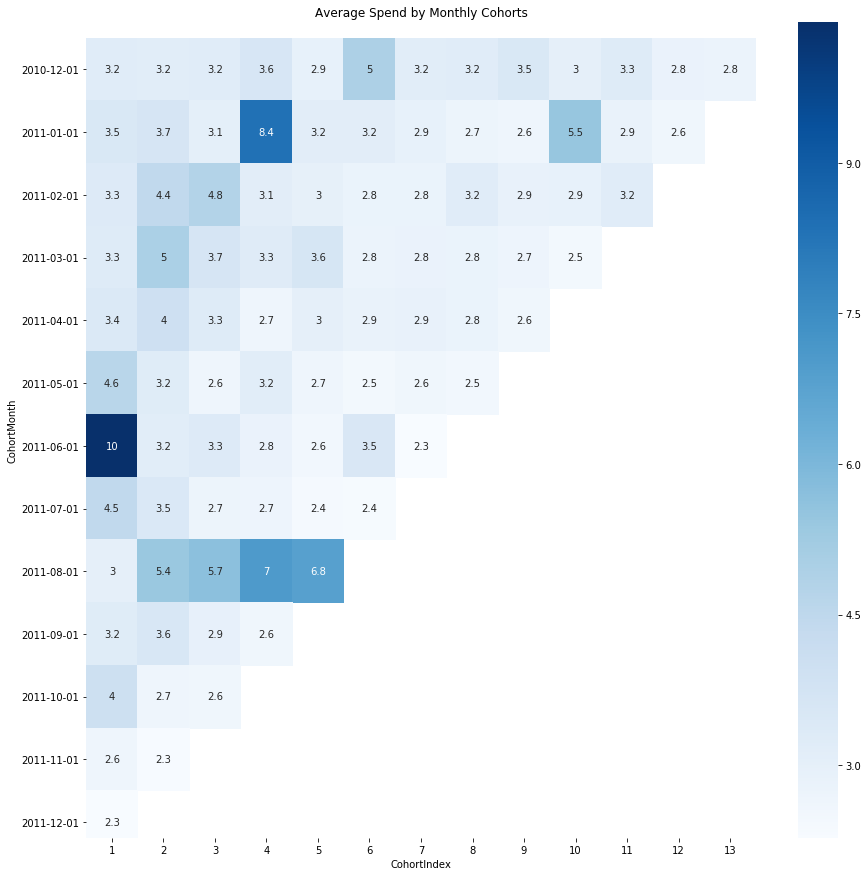

In [110]:
plt.figure(figsize=(15,15))
plt.title('Average Spend by Monthly Cohorts')
chart = sns.heatmap(data=average_price,
           annot=True,
            cmap='Blues',
            yticklabels=retention.index.strftime('%Y-%m-%d')
           )

# Makes sure the plot is visible
chart.set_ylim(len(retention)-0.25, -0.25)
# Rotates the ytick labels
chart.set_yticklabels(
    chart.get_yticklabels(), 
    rotation=0
)
# plt.savefig("filepath/filename.format", bbox_inches='tight')
plt.show()

<b><font color="blue">Note:</font>
 - Average purchase price spent by time cohort fluctuated between 2.3 - 10.4</b>

# Customer Segmentation using Recency, Frequency, and Monetary Segmentation

 - Recency (R) is based on the last purchase
 - Frequency (F) is based on how many purchases have been made in the last 12 months
 - Monetary Value (M)is based on how much customer spent in last 12 months
 - RFM can be grouped by percentiles

### Percenticles <code>pd.qcut()</code>
 - Sort customers based on metric
 - Break customers into a pre-defined number of groups of equal size
 - Assign a label to each group

# Calculate recency, frequency, and monteary calculation

# Step 1: Filter Data to 1 year of transactions

In [134]:
# Create a subset of the dataframe that is filtered for most recent year of activity
subset_df = df[df['InvoiceDate']>'2010-12-10'].copy()

In [135]:
# Confirm subset dates
print('Min: {}; Max: {}'.format(min(subset_df.InvoiceDate),
                              max(subset_df.InvoiceDate)))

Min: 2010-12-10 09:33:00; Max: 2011-12-09 12:50:00


# Step 2: Calculate the Sales Revenue per Transaction

 - This is calculated by <code>Quantity</code> * <code>UnitPrice</code>

In [136]:
# Create a sales revenue column named <code>TotalSum</code>
subset_df["TotalSum"] = subset_df["Quantity"]*subset_df["UnitPrice"]

# Step 3: Calcuate RFM Metrics

In [137]:
# Create snapshot_day
snapshot_date = max(subset_df.InvoiceDate) + dt.timedelta(days=1)

In [141]:
snapshot_date

Timestamp('2011-12-10 12:50:00')

In [138]:
# Aggregate data (Recent day - last transaction)
rfm_data = subset_df.groupby(["CustomerID"]).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo' : 'count',
    'TotalSum' : 'sum'})

In [139]:
# Rename columns for easier interpretation
rfm_data.rename(columns = {'InvoiceDate' : 'Recency',
                          'InvoiceNo' : 'Frequency',
                          'TotalSum': 'Monetary Value'}, inplace=True)

In [140]:
rfm_data.head()

,Recency,Frequency,Monetary Value
CustomerID,,,
12346,326,2,0.00
12347,2,151,3598.21
12348,75,31,1797.24
12349,19,73,1757.55
12350,310,17,334.40


# Building RFM segments

In [ ]:
# Recency quartile (rate recent active greater)
r_labels = range(4,0,-1)

In [ ]:
r_quartiles = pd.qcut(rfm_data["Recency"], 4, labels=r_labels)

In [ ]:
rfm_data = rfm_data.assign(R = r_quartiles.values)

In [ ]:
rfm_data.head()

In [ ]:
f_labels = range(1,5)
m_labels = range(1,5)

In [ ]:
f_quantiles = pd.qcut(rfm_data["Frequency"], 4, labels=f_labels)

In [ ]:
m_quantiles = pd.qcut(rfm_data["Monetary Value"], 4, labels=m_labels)

In [ ]:
rfm_data = rfm_data.assign(F = f_quantiles.values)

In [ ]:
rfm_data = rfm_data.assign(M = m_quantiles.values)

In [ ]:
rfm_data.head()

# Build RFM Segment and RFM Score

 - Concatenate RFM quartile values to RFM_Segment
 - Sum RFM quartiles values to RFM_Score

In [ ]:
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])

In [ ]:
rfm_data['RFM_Segment'] = rfm_data.apply(join_rfm, axis=1)

In [ ]:
rfm_data['RFM_Score'] = rfm_data[['R','F','M']].sum(axis=1)

In [ ]:
rfm_data.head()

# Analyze RFM segments

In [ ]:
# .size() function is used to get an int representing the number of elements in this object.
rfm_data.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

# Filtering on RFM Segments
 - select bottom RFM segment '111' and view top 5 rows

In [ ]:
rfm_data[rfm_data["RFM_Segment"]=='111'][:5]

# Summary Metrics per RFM Score

In [ ]:
rfm_data.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary Value' : ['mean', 'count']}).round(1)

# Group into named segments

In [ ]:
def segment_name(df):
    if df['RFM_Score'] >= 9:
        return 'Gold'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
        return 'Silver'
    else:
        return 'Bronze'

In [ ]:
rfm_data["General_Segment"] = rfm_data.apply(segment_name, axis=1)

In [ ]:
rfm_data.groupby('General_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary Value' : ['mean', 'count']}).round(1)

# K-means clustering

 - Simple and fast
 - Most popular supervised learning model

### Assumptions
 - Distributions are symmetric
 - Variables have same average values (scale)
 - variables with same variance (scale)

### Evaluate data skewness
 - Apply logarithmic transformation if skewed
 - Only works on positive values

### Calculate statistics of variables

In [ ]:
rfm_data.describe()

### Manage data skewness

In [ ]:
# Plot distribution
rfm_variables = ["Recency", "Frequency", "Monetary Value"]
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for axes, var in zip(axes.ravel(), rfm_variables):
    axes.set_title(var)
    sns.distplot(rfm_data[var], ax=axes)

plt.tight_layout()
# plt.savefig("filepath/filename.format", bbox_inches='tight')
plt.show()

### Data transformation

In [ ]:
frequency_log = np.log(rfm_data.Frequency)
recency_log = np.log(rfm_data.Recency)

In [ ]:
data = {"frequency_log": frequency_log, "recency_log": recency_log}
rf_log = pd.DataFrame.from_dict(data)

In [ ]:
# Plot distribution
rfm_log_variables = rf_log.columns
fig, axes = plt.subplots(1, 2, figsize=(8,4))
for axes, var in zip(axes.ravel(), rfm_log_variables):
    axes.set_title(var)
    sns.distplot(rf_log[var], ax=axes)

plt.tight_layout()
# plt.savefig("filepath/filename.format", bbox_inches='tight')
plt.show()

### Dealing with negative values

# Centering and Scaling Variables

 - Centering variables id done by subtracting average values from each observation

In [ ]:
# Aggregate data (Recent day - last transaction)
rfm_dataset = subset_df.groupby(["CustomerID"]).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo' : 'count',
    'TotalSum' : 'sum'})

In [ ]:
# Rename columns for easier interpretation
rfm_dataset.rename(columns = {'InvoiceDate' : 'Recency',
                          'InvoiceNo' : 'Frequency',
                          'TotalSum': 'Monetary Value'}, inplace=True)

In [ ]:
rfm_dataset = rfm_dataset[rfm_dataset["Monetary Value"]>0]

In [ ]:
rfm_dataset.head()

# Combining centering and scaling
 - use scaler from <code>scikit-learn</code>

In [ ]:
scaler = StandardScaler()
scaler.fit(rfm_datav2)
rfm_normalized = scaler.transform(rfm_datav2)

In [ ]:
print('mean:', rfm_normalized.mean(axis=0).round(2))
print('std:', rfm_normalized.std(axis=0).round(2))

# Sequence of structuring pre-processing steps

 - Unskew the data - log transformation
 - Standardize to the same average values
 - Scale to the same standard deviation
 - Store as a separate array to be used for clustering

In [ ]:
# Unskew the data with log transformation
dataset_log = np.log(rfm_dataset)

In [ ]:
dataset_log.head()

In [ ]:
# Normalize the variables with <code>StandardScaler</code>
scaler = StandardScaler()
scaler.fit(dataset_log)

In [ ]:
dataset_normalized = scaler.transform(dataset_log)
df_normalized = pd.DataFrame(dataset_normalized, index=rfm_dataset.index, columns=rfm_dataset.columns)

In [ ]:
df_normalized.head()

In [ ]:
# Plot distribution
rfm_variables = df_normalized.columns
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for axes, var in zip(axes.ravel(), rfm_variables):
    axes.set_title(var)
    sns.distplot(df_normalized[var], ax=axes)

plt.tight_layout()
# plt.savefig("filepath/filename.format", bbox_inches='tight')
plt.show()

# Practical Implementation of k-means clustering

 - Data pre-processing
 - Chossing a number of clusters
 - Running k-means clustering on pre-processed data
 - Analyzing average RFM values of each cluster

# Methods to define cluster numbers

 - Visual methods: Elbow criterion
 - Mathematical methods: silhouette coefficient

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=1)

In [ ]:
# compute k-means clustering on pre-processed data
kmeans.fit(df_normalized)

In [ ]:
# Extract cluster labels using <code>labels_</code> attribute
cluster_labels = kmeans.labels_

### Analyze average RFM values of each cluster
 - Create a cluster label column in the original dataframe
 - Calculte average RFM values and size for each cluster

In [ ]:
rfm_dataset_cluster = rfm_dataset.assign(Cluster = cluster_labels)

In [ ]:
rfm_dataset_cluster.groupby(["Cluster"]).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary Value': ["mean", 'count']
}).round(0)

## Elbow citerion method

 - Plot the number of clusters against within-cluster sum-of-squared-erros (SSE)- sum of squared distances from every data point to their cluster center
 - The 'Elbow' represents an 'optimal' number of clusters

In [ ]:
# Create an empty dictionary
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(df_normalized)
    sse[k] = kmeans.inertia_

In [ ]:
# Plot SSE for each k 'cluster'
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
# plt.savefig("filepath/filename.format", bbox_inches='tight')
plt.show()

### Criteria points to 2 or 3 cluster solutions

## Experimental Approach - Analyze Segments

 - Build clustering at and around elbow solution
 - Analyze average RFM values
 - Compare against other solutions and identify which provides most insight

In [ ]:
kmeans3 = KMeans(n_clusters=3, random_state=1)
# compute k-means clustering on pre-processed data
kmeans3.fit(df_normalized)
# Extract cluster labels using <code>labels_</code> attribute
cluster_labels = kmeans3.labels_
rfm_dataset_cluster3 = rfm_dataset.assign(Cluster = cluster_labels)
rfm_dataset_cluster3.groupby(["Cluster"]).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary Value': ["mean", 'count']
}).round(0)

### Profile and Interpret Segments

Approaches to build customer personals
 - Summary statistics for each cluster
 - Snake plots
 - Calcualte relative importance of cluster attributes compared to population

As done above

### Snake plots
 - Market research technique to compare different segments
 - Visual representation of each segment's attributes
 - Need to first normalize data (center and scale)
 - Plot each clusters average normalized values of each attribute

In [ ]:
df_normalized['Cluster'] = rfm_dataset_cluster3['Cluster']

In [ ]:
df_melt = pd.melt(df_normalized.reset_index(),
                 id_vars=['CustomerID', 'Cluster'],
                 value_vars = ['Recency', 'Frequency', 'Monetary Value'],
                  var_name='Attribute',
                  value_name='Value'
                 )

In [ ]:
plt.title('Snake plot of standardized values')
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=df_melt)
# plt.savefig("filepath/filename.format", bbox_inches='tight')
plt.show()

### Relative importance of segment attributes
 - identify relative importance of each segment's attribute
 - calculate average values of each cluster
 - calcualte average values of population

In [ ]:
cluster_avg = rfm_dataset_cluster3.groupby(['Cluster']).mean()
population_avg = rfm_dataset.mean()

In [ ]:
relative_imp = cluster_avg/population_avg - 1

### Analyze and plot relative importance

 - further ratio is from 0, the more important that attribute is for a segment, relative to the total population

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Relative importance of attributes')
chart = sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
# Makes sure the plot is visible
chart.set_ylim(len(relative_imp)-0.25, -0.25)
# plt.savefig("filepath/filename.format", bbox_inches='tight')
plt.show()